<a href="https://colab.research.google.com/github/SKrishna93/EVA5/blob/master/Sample/EVA5_Session_5_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing torch packages for Neural Network building
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__() 
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1), # Input=28x28x1 Kernel=3x3x1x8 Output=28x28x8 RF=3x3
        nn.ReLU(),
        nn.Conv2d(8, 10, 3, padding=1), # Input=28x28x8 Kernel=3x3x8x10 Output=28x28x10 RF=5x5
        nn.ReLU(),
        nn.Conv2d(10, 10, 3, padding=1), #Input=28x28x10 Kernel=3x3x10x10 Output=28x28x10 RF=7x7
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Input=28x28x10 Output=14x14x10 RF=14x14
        ) #First Convolution and Transistion Block. RF achieved 7x7 during Convolution.

    self.conv2 = nn.Sequential(
        nn.Conv2d(10, 10, 3, padding=1), #Input=14x14x10 Kernel=3x3x10x10 Output=14x14x10 RF=16x16
        nn.ReLU(),
        nn.Conv2d(10, 16, 3, padding=1), #Input=14x14x10 Kernel=3x3x10x16 Output=14x14x16 RF=18x18
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #Input=14x14x16 Output=7x7x16 RF=20x20
        ) #Second Convolution and Transistion block. RF achieved 20x20

    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, 3), #Input=7x7x16 Kernel=3x3x16x32 Output=5x5x32 RF=22x22
        nn.ReLU(),
        nn.Conv2d(32, 32, 3), #Input=5x5x32 Kernel=3x3x32x32 Output=3x3x32 RF=24x24
        nn.AdaptiveAvgPool2d(1), #Input=3x3x32 Kernel=3x3x32 Output=1x1x32
        nn.Conv2d(32, 10, 1) #Input=1x1x32 Kernel=1x1x32x10 Output=1x1x10
        ) #Final Convolution 


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             730
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             910
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,456
             ReLU-11           [-1, 16, 14, 14]               0
        MaxPool2d-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 32, 5, 5]           4,640
             ReLU-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_epoch_end = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  train_epoch_end.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 21):
    print(epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.3032524585723877 Batch_id=468 Accuracy=10.98: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3001, Accuracy: 1135/10000 (11.35%)

2


Loss=0.5093193650245667 Batch_id=468 Accuracy=28.82: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5210, Accuracy: 8494/10000 (84.94%)

3


Loss=0.20668655633926392 Batch_id=468 Accuracy=90.66: 100%|██████████| 469/469 [00:23<00:00, 20.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1921, Accuracy: 9411/10000 (94.11%)

4


Loss=0.13861562311649323 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1202, Accuracy: 9601/10000 (96.01%)

5


Loss=0.11615493148565292 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Accuracy: 9756/10000 (97.56%)

6


Loss=0.03447781130671501 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9795/10000 (97.95%)

7


Loss=0.05475819483399391 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9818/10000 (98.18%)

8


Loss=0.0049295974895358086 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9842/10000 (98.42%)

9


Loss=0.024679189547896385 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9848/10000 (98.48%)

10


Loss=0.09145479649305344 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9843/10000 (98.43%)

11


Loss=0.03069002740085125 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9854/10000 (98.54%)

12


Loss=0.035012442618608475 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9870/10000 (98.70%)

13


Loss=0.043116599321365356 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9881/10000 (98.81%)

14


Loss=0.02485192008316517 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9878/10000 (98.78%)

15


Loss=0.008209648542106152 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9868/10000 (98.68%)

16


Loss=0.02974817156791687 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9878/10000 (98.78%)

17


Loss=0.032584622502326965 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9858/10000 (98.58%)

18


Loss=0.01064968854188919 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9876/10000 (98.76%)

19


Loss=0.0007292020600289106 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9889/10000 (98.89%)

20


Loss=0.11147021502256393 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:22<00:00, 20.56it/s]



Test set: Average loss: 0.0398, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

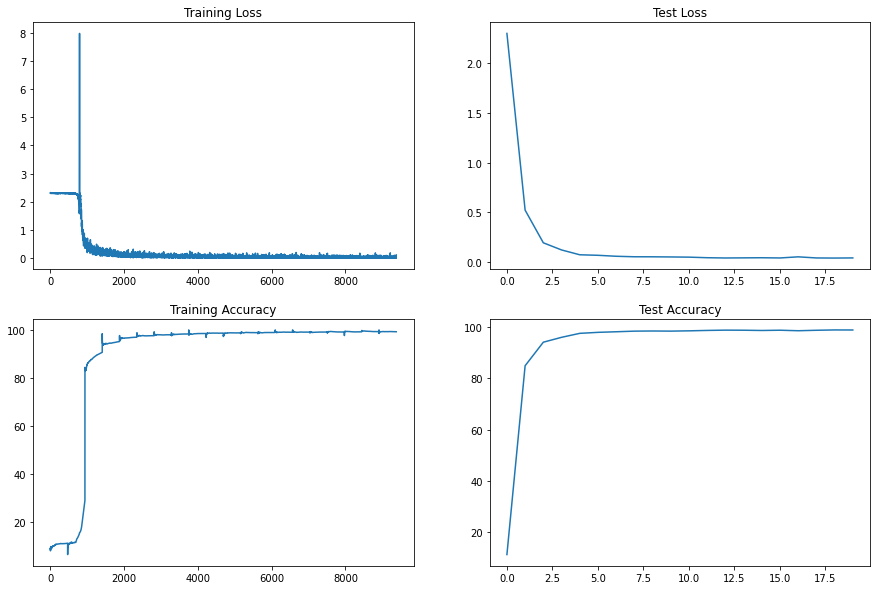

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

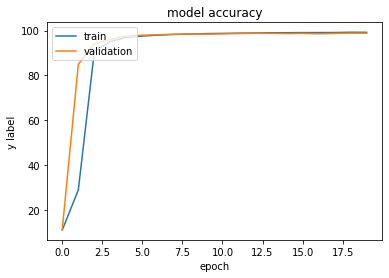

Best Train Accuracy: 99.29%
Best Test Accuracy: 98.89%


In [11]:
plt.plot(train_epoch_end)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('y label')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print('Best Train Accuracy: {:.2f}%'.format(max(train_epoch_end[:])))
print('Best Test Accuracy: {:.2f}%'.format(max(test_acc[:])))

# Model 1
### Objective


*   Build a base network for our model. Inspired from previous assignment
*   Target Test and Train accuracy of above 98%
*   < 20k parameters and < 20 Epochs

### Summary


*   Basic model with 19k parameters
*   Test Accuracy:  99.29%
*   Train Accuracy: 98.89%
*   Slight overfitting observed in the model (Can be fixed in the subsequent iterations by adding BatchNorm and Regulariaztion)
*   Network is built with two convolution blocks each followed by two transition blocks
*   

